In [195]:
import numpy as np
import matplotlib.pyplot as plt

In [196]:
#reading dataset
dataset = np.load('dataset.npz')

In [197]:
# input data
x_true=dataset['x_true']
y_true=dataset['y_true']
t=dataset['t']
th_true=dataset['th_true']
l=dataset['l']
r=dataset['r']
b=dataset['b']
v=dataset['v']
om=dataset['om']
d=dataset['d']
r_var=dataset['r_var']
b_var=dataset['b_var']
v_var=dataset['v_var']
om_var=dataset['om_var']
dist=d[0,0]
rvar=r_var[0,0]
bvar=b_var[0,0]
# b=2*np.pi*((b-b.min())/(b.max()-b.min()))-np.pi
print(b[0,0])
# print(r.min())

0.0


In [198]:
####----Prediction Step----####
def prediction(vt,wt,mu,sigma):
    
    x=mu[0]
    y=mu[1]
    theta=mu[2]

    #mean update
    mu_pred=mu+(0.1)*(np.array([[vt*np.cos(theta),vt*np.sin(theta),wt]]).T)

    #motion noise
    l=v_var*np.cos(theta)
    vx_var=l[0][0]
    l=v_var*np.sin(theta)
    vy_var=l[0][0]
    w_var=om_var[0][0]
    Q=np.array([[v_var[0][0] , 0.0 , 0.0 ],\
                [0.0 , v_var[0][0] , 0.0 ],\
                [0.0 , 0.0 ,  w_var ]])

    #Jacobian of 'g' wrt mu
    vs=vt*np.sin(theta)
    vc=vt*np.cos(theta)
    G =np.array([[1 , 0 , -0.1*vs[0] ],\
                 [0 , 1 ,  0.1*vc[0] ],\
                 [0 , 0 ,  1      ]])
    
    #mean and covariance update
    mu = mu_pred
    sigma = np.dot(np.dot(G,sigma),np.transpose(G))+Q
    return mu,sigma

In [199]:
####----Correction Step----####
def correction(mu,sigma,l,rt,bt,dist,rvar,bvar):
    x=mu[0,0]
    y=mu[1,0]
    theta=mu[2,0]
    H=np.zeros((34,3))
    pred_obs=np.zeros((34,1))
    true_obs=np.zeros((34,1))
    
    #true observations
    for i in range(17):
        if (i==0):
            true_obs[i]=rt[i]
            j=i+1
            true_obs[j]=bt[i]
        else:
            true_obs[j+i]=rt[i]
            true_obs[j+i+1]=bt[i]
            j=j+1

    #predicted observations
    j=0
    for i in range(17):        
        if (rt[i]!=0 and rt[i]<6):
            pred_obs[2*i,0]=((l[i,0]-x-dist*np.cos(theta))**2+(l[i,1]-y-dist*np.sin(theta))**2)**(1/2)
            pred_obs[2*i+1,0]=np.arctan2(l[i,1]-y-dist*np.sin(theta),l[i,0]-x-dist*np.cos(theta))-theta
        else:
            pred_obs[2*i,0]=0
            pred_obs[2*i+1,0]=0
    norm_bearing=np.zeros((17,1))
    for i in range(17):
        norm_bearing=pred_obs[2*i+1,0]
        while norm_bearing <= -np.pi :
            norm_bearing+=2*np.pi
        while norm_bearing > np.pi :
            norm_bearing-=2*np.pi
        pred_obs[2*i+1,0]=norm_bearing
        
    #sensor noise matrix "R" 34x34
    q2=np.array([rvar,bvar])
    u=np.array([rvar,bvar])
    for i in range(16):
        u=np.hstack((u,q2))
    R=np.diag(u)

    #Jacobian of 'h' wrt mu
    for i in range(17):
        xdiff=l[i,0]-x-dist*np.cos(theta)
        ydiff=l[i,1]-y-dist*np.sin(theta)
        sqrt=np.sqrt(xdiff**2+ydiff**2)
        H[2*i,0]=(1/sqrt)*(-xdiff)
        H[2*i,1]=(-ydiff/sqrt)
        H[2*i,2]=((xdiff*np.sin(theta)-ydiff*np.cos(theta))/sqrt)*dist
        H[2*i+1,0]=ydiff/(sqrt**2)
        H[2*i+1,1]=-xdiff/(sqrt**2)
        H[2*i+1,2]=-((xdiff*np.cos(theta)+ydiff*np.sin(theta))/(sqrt**2))*dist -1
    invert=(H@sigma@(H.T))+R
    np.array(invert)
    invert.astype('float64')
    
    #Kalman Gain
    Kinv = np.linalg.inv(invert)
    Kt = np.dot(np.dot(sigma,np.transpose(H)),Kinv)
    
    #Updating mean and sigma using corrections
    disparity=(true_obs-pred_obs)
    I=np.eye(3)
    mu = mu + (1)*np.dot(Kt,disparity)
    sigma=np.dot((I-np.dot(Kt,H)),sigma)
    
    return mu,sigma

In [200]:
####-----MAIN LOOP----####

#Initialization
mu = np.array([3.01975613,0.07089905, -2.91015736]).T
mu=mu.reshape((3,1))
x_pred=[]
y_pred=[]
x_pred.append(3.01975613)
y_pred.append(0.07089905)

sigma =np.array([[1.0,0.0 , 0.0],[0.0, 1.0 , 0.0],[0.0, 0.0 , 0.1]])
# print(mu)
for i in range(len(t)):
    mu,sigma = prediction(v[i],om[i],mu,sigma)
    mu=mu.reshape((3,1))
#     print("PREDICTIONS:")
#     print(mu)
#     print(sigma)
    mu,sigma = correction(mu,sigma,l,r[i],b[i],dist,rvar,bvar)
    mu=mu.reshape((3,1))
    x_pred.append(mu[0,0])
    y_pred.append(mu[1,0])
#     print("CORRECTION at time-step:",i)
print("EKF Correction Done!")

EKF Correction Done!


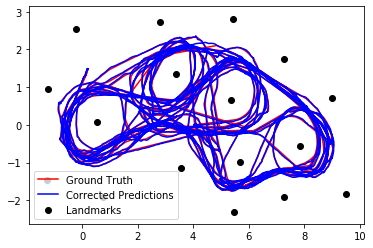

In [201]:
plt.plot(x_true,y_true,c="red",label='Ground Truth');
plt.scatter(l[:,0],l[:,1],c='black',label='Landmarks');
plt.plot(x_pred,y_pred,c='blue',label='Corrected Predictions');
# plt.scatter(l[:,0],l[:,1],c='black');
plt.legend();

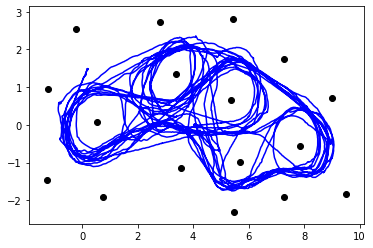

In [202]:
plt.plot(x_pred,y_pred,c='blue');
plt.scatter(l[:,0],l[:,1],c='black');

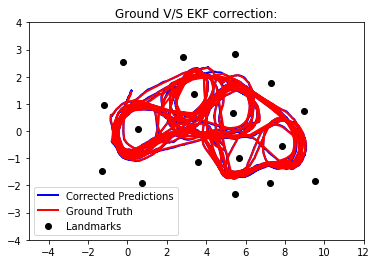

In [210]:
from matplotlib import animation, rc
from IPython.display import HTML
fig, ax = plt.subplots()
ax.set_xlim(( -5, 12))
ax.set_ylim((-4, 4))
line, = ax.plot([], [],lw=2,c="blue",label='Corrected Predictions')
line1, = ax.plot([], [],lw=2,c="red",label='Ground Truth')
ax.scatter(l[:,0],l[:,1],c='black',label='Landmarks')
plt.title('Ground V/S EKF correction:')
ax.legend()
def init():
    line.set_data([], [])
    line1.set_data([], [])
    return (line,line1)
def animate(i):
    x_corr = x_pred[:i]
    y_corr = y_pred[:i]
    x_gnd = x_true[:i]
    y_gnd = y_true[:i]    
    line.set_data(x_corr, y_corr)
    line1.set_data(x_gnd, y_gnd)
#     ax.scatter(x_pred[i],y_pred[i],c="blue",label='True Position')
#     ax.scatter(x_true[i],y_true[i],c="red",label='EKF Predicted Position')
    return (line,line1)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=12600, interval=1, blit=True)
# ax.legend()
HTML(anim.to_html5_video())

In [153]:
from matplotlib.patches import Ellipse
def plot_cov_ellipse(cov, pos, nstd=3, ax=None, **kwargs):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(vecs[0,0],vecs[1,0]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals[:2])
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

[[3.39652345]
 [0.21657836]]


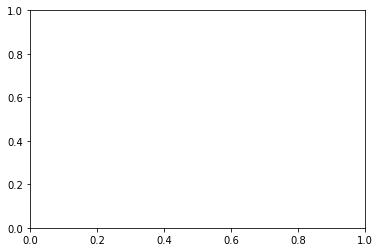

In [154]:
print(mu[:2])
plot_cov_ellipse(sigma,mu[:2],3)
plt.show()